In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from functools import partial
from rdkit import Chem
from rdkit import rdBase
from rdkit import RDPaths
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem.Draw import SimilarityMaps, IPythonConsole
from IPython.display import SVG
import io
from PIL import Image
import rdkit
import numpy as np
print(rdkit.__version__)

2019.09.2


RDKit WARNING: [18:36:41] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
trainpath = os.path.join(RDPaths.RDDocsDir,'Book/data/solubility.train.sdf')
testpath =  os.path.join(RDPaths.RDDocsDir,'Book/data/solubility.test.sdf')

In [4]:
train_mols = [m for m in Chem.SDMolSupplier(trainpath) if m is not None]
test_mols = [m for m in Chem.SDMolSupplier(testpath) if m is not None]

val_dict = {'(A) low':0,
           '(B) medium':1,
           '(C) high':2}

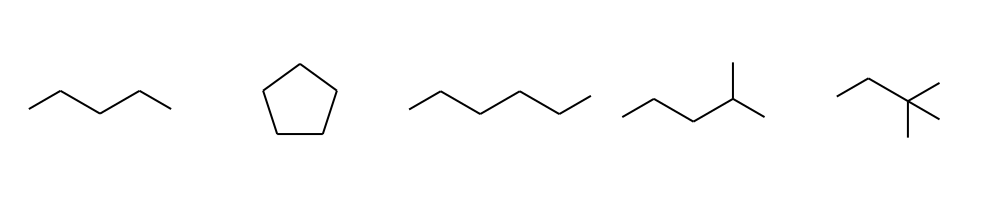

In [5]:
Draw.MolsToGridImage(train_mols[:5], molsPerRow=5)

In [6]:
print(train_mols[0].GetPropsAsDict())

{'ID': 1, 'NAME': 'n-pentane', 'SOL': -3.18, 'SOL_classification': '(A) low', 'smiles': 'CCCCC'}


In [7]:
def mol2arr(mol, fpfunc):
    fp = fpfunc(mol)
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [8]:
# https://rdkit.blogspot.com/2020/01/similarity-maps-with-new-drawing-code.html
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

In [9]:
fpfunc = partial(SimilarityMaps.GetMorganFingerprint, nBits=1024, radius=2)

In [10]:
trainX = [fpfunc(m) for m in train_mols]
trainY = [val_dict[m.GetProp('SOL_classification')] for m in train_mols]

testX = [fpfunc(m) for m in test_mols]
testY = [val_dict[m.GetProp('SOL_classification')] for m in test_mols]

In [11]:
rfc = RandomForestClassifier(random_state=794)

In [12]:
rfc.fit(trainX, trainY)

/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=794,
                       verbose=0, warm_start=False)

In [13]:
# https://www.rdkit.org/docs/Cookbook.html
# Following example I would like to get probability of High solubility
def getProba(fp, predctionFunction):
    return predctionFunction((fp,))[0][2]

In [14]:
def drawmol(mols, idx):
    d = Draw.MolDraw2DCairo(1,1)
    _, maxWeight = SimilarityMaps.GetSimilarityMapForModel(mols[idx],fpfunc, 
                                                           lambda x: getProba(x, rfc.predict_proba),
                                                           colorMap='coolwarm',
                                                          size=(200,200),
                                                          step=0.001,
                                                          alpha=0.2)
    d.FinishDrawing()
    show_png(d.GetDrawingText())
    print(mols[idx].GetProp('SOL_classification'))

In [15]:
high_test_mols = [mol for mol in test_mols if mol.GetProp('SOL_classification') == '(C) high']
low_test_mols = [mol for mol in test_mols if mol.GetProp('SOL_classification') == '(A) low']


(C) high


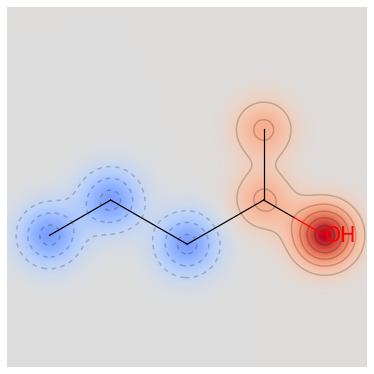

In [16]:
drawmol(high_test_mols, 0)

(C) high


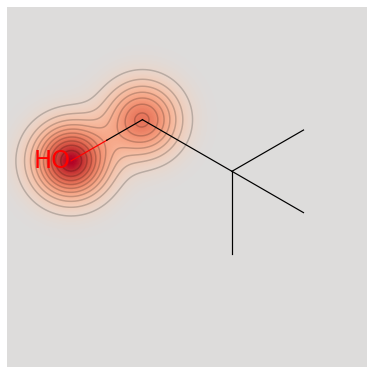

In [17]:
drawmol(high_test_mols, 1)

(C) high


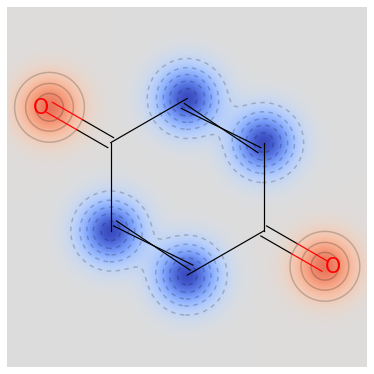

In [18]:
drawmol(high_test_mols, 10)

(C) high


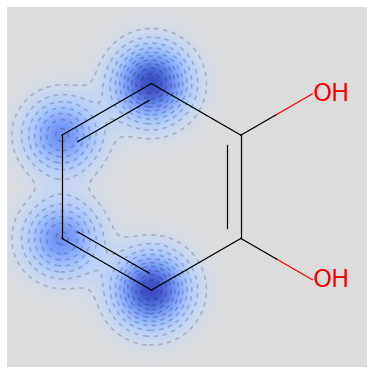

In [19]:
drawmol(high_test_mols, 5)

(A) low


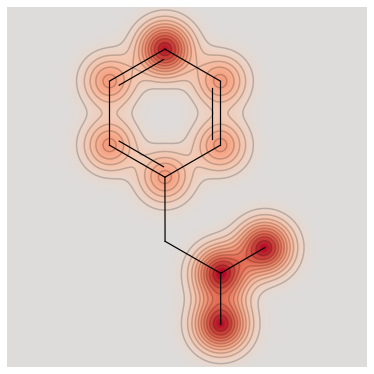

In [20]:
drawmol(low_test_mols, 5)

(A) low


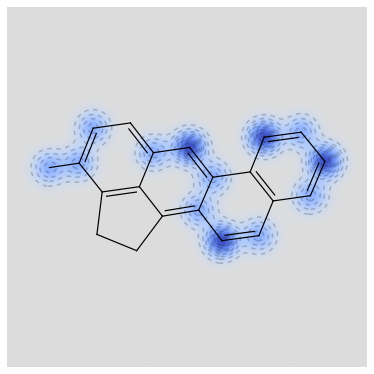

In [21]:
drawmol(low_test_mols, 15)